In [1]:
!pip install replicate

import replicate
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00


Import json file from wikihow

In [2]:
import json

from google.colab import files
uploaded = files.upload()

file_name = next(iter(uploaded))

with open(file_name, 'r') as file:
    data = json.load(file)

main_goal = data['title']

wiki_steps = []

for part in data['parts']:
    for step in part['steps']:
        wiki_steps.append(step['headline'])

Saving 1503_soothe-a-teething-baby.json to 1503_soothe-a-teething-baby.json


In [3]:
wiki_steps

["Rub your baby's gums with a clean finger.",
 "Keep your baby's mouth cool.",
 'Invest in a teething device.',
 'Give your baby hard foods.',
 'Dry any drool you see.',
 'Try over-the-counter drugs.',
 'Use teething gels.',
 'Be cautious when trying homeopathic cures.',
 'Know when to see a doctor.',
 'Take your baby to the dentist.',
 "Care for your baby's new teeth.",
 'Prevent tooth decay by feeding your baby a healthy diet.']

In [4]:
os.environ['REPLICATE_API_TOKEN'] = 'r8_e4mEdTT4wmpHuZB2RHxxw8Gr6xAlEWS33mK6e'
api = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])
text = ""
input = {
    "top_p": 1,
    "prompt": main_goal,
    "temperature": 0.75,
    "system_prompt": "You are a helpful assistant that helps users break down their goals into smaller steps to help them achieve their goal. Make a numbered list of the steps to achieve the goal.",
    "max_new_tokens": 800,
    "repetition_penalty": 1
}

for event in api.stream(
    "meta/llama-2-7b-chat",
    input=input
): text += str(event)

In [5]:
print(text)

 Sure, I'd be happy to help you break down your goal of soothing a teething baby into smaller steps! Here are some steps you can follow:

1. Check for signs of teething: Before you can start soothing your baby, it's important to check for signs of teething. Look for symptoms such as drooling, gnawing or chewing on their hands, or swelling of the gums.
2. Provide a cold compress: One of the most effective ways to soothe a teething baby is to provide a cold compress. You can use a cold washcloth or a frozen teether toy. Place the compress on your baby's gums or cheek to help reduce swelling and ease discomfort.
3. Use over-the-counter pain relievers: If your baby is older than 6 months, you can try using over-the-counter pain relievers such as acetaminophen or ibuprofen. Always follow the recommended dosage instructions and consult with your pediatrician before giving your baby any medication.
4. Massage your baby's gums: Gently massaging your baby's gums with your finger can help to sti

Put Llama 2 output into a list

In [6]:
import re

llama_steps = []

lines = text.splitlines()

pattern = re.compile(r'^\d+\.\s+(.*)')

for line in lines:
    match = pattern.match(line)
    if match:
        step_text = match.group(1)
        llama_steps.append(step_text)

In [7]:
llama_steps

["Check for signs of teething: Before you can start soothing your baby, it's important to check for signs of teething. Look for symptoms such as drooling, gnawing or chewing on their hands, or swelling of the gums.",
 "Provide a cold compress: One of the most effective ways to soothe a teething baby is to provide a cold compress. You can use a cold washcloth or a frozen teether toy. Place the compress on your baby's gums or cheek to help reduce swelling and ease discomfort.",
 'Use over-the-counter pain relievers: If your baby is older than 6 months, you can try using over-the-counter pain relievers such as acetaminophen or ibuprofen. Always follow the recommended dosage instructions and consult with your pediatrician before giving your baby any medication.',
 "Massage your baby's gums: Gently massaging your baby's gums with your finger can help to stimulate blood flow and ease discomfort. Use your index and middle fingers to massage the gums in a circular motion.",
 'Try teething toys

Dynamic Time Warping? + BLEU Scores

In [8]:
!pip install nltk fastdtw dtaidistance

import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
from dtaidistance import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import pandas as pd
from nltk.translate.bleu_score import SmoothingFunction
import itertools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.2 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512610 sha256=91698958689363eeb2c25222548079220c16f0f4cffe4890c62cf39018a91b89
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
# Tokenize sentences
wiki_tokenized = [nltk.word_tokenize(sentence) for sentence in wiki_steps]
llama_tokenized = [nltk.word_tokenize(sentence) for sentence in llama_steps]

smoothing_function = SmoothingFunction().method1

# BLEU score matrix
bleu_matrix = np.zeros((len(wiki_steps), len(llama_steps)))

for i, ref in enumerate(wiki_tokenized):
    for j, hyp in enumerate(llama_tokenized):
        bleu_matrix[i, j] = sentence_bleu([ref], hyp, smoothing_function=smoothing_function)

# Display the BLEU similarity matrix as a DataFrame for better readability
bleu_df = pd.DataFrame(bleu_matrix, index=[f"wiki_{i}" for i in range(len(wiki_steps))],
                       columns=[f"llama_{j}" for j in range(len(llama_steps))])

print("BLEU Similarity Matrix:")
print(bleu_df)

BLEU Similarity Matrix:
          llama_0   llama_1   llama_2   llama_3   llama_4   llama_5   llama_6  \
wiki_0   0.011130  0.047574  0.010284  0.096727  0.011326  0.005641  0.005960   
wiki_1   0.010526  0.018368  0.009570  0.024575  0.010540  0.005098  0.005012   
wiki_2   0.004978  0.008083  0.004089  0.010814  0.005927  0.005641  0.006596   
wiki_3   0.009796  0.008083  0.009570  0.010814  0.010540  0.005098  0.005012   
wiki_4   0.004978  0.003454  0.005382  0.004621  0.004504  0.004287  0.005012   
wiki_5   0.004186  0.003454  0.004863  0.004621  0.005356  0.005098  0.005960   
wiki_6   0.004978  0.004107  0.004863  0.005495  0.005356  0.005641  0.005960   
wiki_7   0.004186  0.003454  0.004089  0.004621  0.004504  0.004287  0.005012   
wiki_8   0.004978  0.004545  0.004089  0.006081  0.005927  0.005641  0.006596   
wiki_9   0.011130  0.009184  0.010284  0.012288  0.011976  0.005641  0.006596   
wiki_10  0.011130  0.018368  0.009570  0.024575  0.010540  0.005098  0.005012   
wiki

In [10]:
# Calculate the maximum BLEU score for each llama entry
max_bleu_scores = np.max(bleu_matrix, axis=0)

# Calculate the average of the maximum BLEU scores
average_max_bleu = np.mean(max_bleu_scores)


max_indices = np.argmax(bleu_matrix, axis=0)

# Print the corresponding sentence matchups
print("Maximum BLEU score sentence matchups:")
for j, max_index in enumerate(max_indices):
    print(f"LLama: {llama_steps[j]} -> Wiki: {wiki_steps[max_index]}")

print("\nMaximum BLEU scores for each 'llama' entry:")
print(max_bleu_scores)
print("\nAverage of the maximum BLEU scores:", average_max_bleu)

Maximum BLEU score sentence matchups:
LLama: Check for signs of teething: Before you can start soothing your baby, it's important to check for signs of teething. Look for symptoms such as drooling, gnawing or chewing on their hands, or swelling of the gums. -> Wiki: Rub your baby's gums with a clean finger.
LLama: Provide a cold compress: One of the most effective ways to soothe a teething baby is to provide a cold compress. You can use a cold washcloth or a frozen teether toy. Place the compress on your baby's gums or cheek to help reduce swelling and ease discomfort. -> Wiki: Rub your baby's gums with a clean finger.
LLama: Use over-the-counter pain relievers: If your baby is older than 6 months, you can try using over-the-counter pain relievers such as acetaminophen or ibuprofen. Always follow the recommended dosage instructions and consult with your pediatrician before giving your baby any medication. -> Wiki: Rub your baby's gums with a clean finger.
LLama: Massage your baby's gum

Plot the maximum Bleu Scores

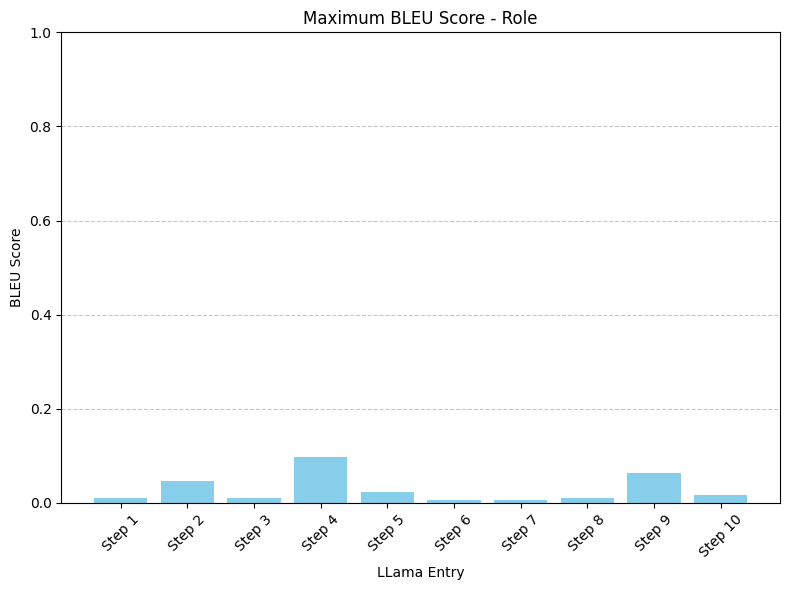

In [11]:
import matplotlib.pyplot as plt

# Plot the maximum BLEU scores
plt.figure(figsize=(8, 6))
plt.bar(range(len(llama_steps)), max_bleu_scores, color='skyblue')
plt.xlabel('LLama Entry')
plt.ylabel('BLEU Score')
plt.title('Maximum BLEU Score - Role')
plt.xticks(range(len(llama_steps)), ['Step ' + str(i+1) for i in range(len(llama_steps))], rotation=45)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()